# Taller Práctico: Regresión Logística (Versión Completa y Corregida)

**Curso:** Maestría en Machine Learning

**Nota:** Esta versión incorpora las correcciones de preprocesamiento discutidas: la correcta creación de variables dummy (0/1) y la estandarización de features numéricos, presentando el flujo de trabajo metodológicamente correcto y completo.

## 1. Importación de Librerías

In [ ]:
!pip install ISLP

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Librerías de Machine Learning (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Librería para cargar el dataset
from ISLP import load_data

## 2. Carga y Preprocesamiento de Datos

In [52]:
# Carga de datos
default_df = load_data('Default')

# Conversión de categóricas a numéricas
df_processed = pd.get_dummies(default_df, columns=['student'], drop_first=True, dtype=int)
df_processed['default'] = df_processed['default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Definición de features y target
X = df_processed[['balance', 'income', 'student_Yes']]
y = df_processed['default']

print("Primeras filas de los datos preprocesados:")
display(X.head())

Primeras filas de los datos preprocesados:


,balance,income,student_Yes
0,729.526495,44361.625074,0
1,817.180407,12106.134700,1
2,1073.549164,31767.138947,0
3,529.250605,35704.493935,0
4,785.655883,38463.495879,0


### División en Conjuntos de Entrenamiento y Prueba

Dividimos los datos ANTES de cualquier preprocesamiento que "aprenda" de los datos, como la estandarización, para evitar fuga de información.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (8000, 3)
Forma de X_test: (2000, 3)


### Estandarización de Features Numéricos

**Este es un paso crucial.** Estandarizamos las variables `balance` e `income` para que tengan media 0 y desviación estándar 1. Esto asegura que la regularización del modelo se aplique de manera justa.

**Importante:** Ajustamos el `StandardScaler` **únicamente** con los datos de entrenamiento (`X_train`) y luego lo usamos para transformar tanto el conjunto de entrenamiento como el de prueba.

In [54]:
# Instanciamos el escalador
scaler = StandardScaler()

# Columnas a escalar
cols_to_scale = ['balance', 'income']

# Creamos copias para no modificar los dataframes originales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transformamos los datos de prueba con el escalador ya ajustado
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Primeras filas de los datos de entrenamiento escalados:")
display(X_train_scaled.head())

Primeras filas de los datos de entrenamiento escalados:


,balance,income,student_Yes
2720,-0.018061,-0.331140,1
6168,-1.687480,2.194023,0
7723,-0.123917,-0.288274,0
8128,0.155670,0.992420,0
3565,0.449485,-1.673192,1


## 3. Entrenamiento del Modelo de Regresión Logística

Ahora entrenaremos el modelo usando los datos estandarizados.

In [40]:
# Instanciamos y entrenamos el modelo con los datos escalados
log_reg = LogisticRegression(random_state=42)#, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente con datos escalados!")

¡Modelo entrenado exitosamente con datos escalados!


## 4. Evaluación del Modelo

Procedemos a la evaluación completa del modelo sobre el conjunto de prueba escalado.

### 4.1. Matriz de Confusión y Métricas Clave

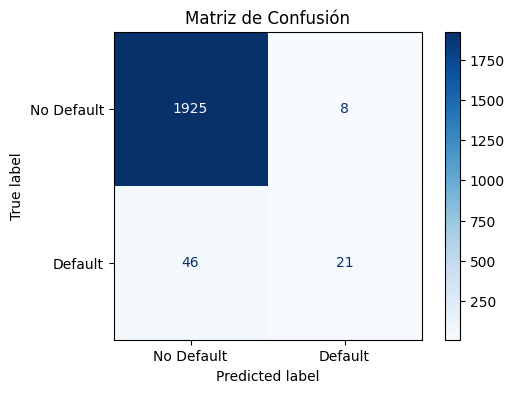


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.98      1.00      0.99      1933
     Default       0.72      0.31      0.44        67

    accuracy                           0.97      2000
   macro avg       0.85      0.65      0.71      2000
weighted avg       0.97      0.97      0.97      2000



In [6]:
# Realizamos predicciones sobre el conjunto de prueba escalado
y_pred = log_reg.predict(X_test_scaled)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

### 4.2. El Impacto del Umbral de Decisión

Reporte de Clasificación con Umbral = 0.2:
              precision    recall  f1-score   support

  No Default       0.99      0.97      0.98      1933
     Default       0.39      0.63      0.48        67

    accuracy                           0.95      2000
   macro avg       0.69      0.80      0.73      2000
weighted avg       0.97      0.95      0.96      2000



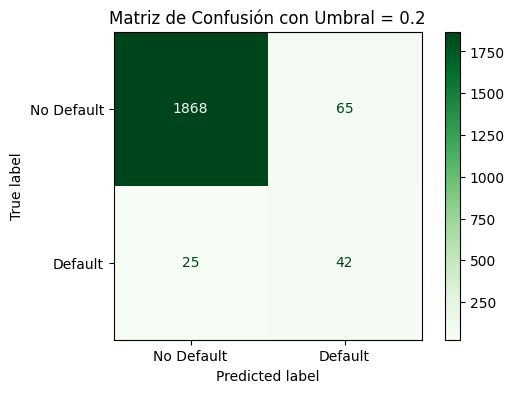

In [7]:
# Obtenemos las probabilidades de predicción para la clase positiva (Default)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Aplicamos un nuevo umbral de 0.2 para aumentar el Recall
umbral = 0.2
y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)

print(f"Reporte de Clasificación con Umbral = {umbral}:")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['No Default', 'Default']))

# Visualizamos la nueva matriz de confusión
cm_nuevo = confusion_matrix(y_test, y_pred_nuevo_umbral)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_nuevo.plot(cmap='Greens', ax=ax)
ax.set_title(f'Matriz de Confusión con Umbral = {umbral}')
plt.show()

### 4.3. Curva ROC y AUC

In [8]:
# Calculamos la tasa de verdaderos positivos (tpr) y la tasa de falsos positivos (fpr)
fpr, tpr, umbrales = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Creamos el gráfico con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Curva ROC (AUC = {auc:.4f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Clasificador Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title='Curva ROC para el Modelo de Regresión Logística',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig.show()

In [9]:
pd.DataFrame({
    'Umbral': umbrales,
    'FPR': fpr,
    'TPR': tpr
})  # Mostramos las primeras filas de los umbrales y sus correspondientes FPR y TPR

,Umbral,FPR,TPR
0,inf,0.000000,0.000000
1,0.904982,0.000000,0.014925
2,0.876104,0.000000,0.029851
3,0.861995,0.000517,0.029851
4,0.723316,0.000517,0.179104
...,...,...,...
87,0.007660,0.320228,0.970149
88,0.007620,0.320228,0.985075
89,0.007012,0.332644,0.985075
90,0.007008,0.332644,1.000000


## 5. Regularización

El hiperparámetro `C` en `scikit-learn` es el inverso de la fuerza de regularización $\lambda$. Un valor de `C` pequeño implica una regularización más fuerte. Ahora que los datos están escalados, la comparación de coeficientes es mucho más justa.

In [10]:
# Modelo con regularización L2 (Ridge) - C=1.0 (default)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Modelo con regularización L1 (Lasso) - C=1.0 (default)
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Ahora con regularización más fuerte (C=0.1)
log_reg_l2_strong = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)
log_reg_l1_strong = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42).fit(X_train_scaled, y_train)

# Creamos un DataFrame para comparar los coeficientes
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coef_L2 (C=1.0)': log_reg_l2.coef_[0],
    'Coef_L1 (C=1.0)': log_reg_l1.coef_[0],
    'Coef_L2_fuerte (C=0.1)': log_reg_l2_strong.coef_[0],
    'Coef_L1_fuerte (C=0.1)': log_reg_l1_strong.coef_[0]
})

print("Comparación de Coeficientes con Regularización (Datos Escalados):")
display(coef_df)

Comparación de Coeficientes con Regularización (Datos Escalados):


,Predictor,Coef_L2 (C=1.0),Coef_L1 (C=1.0),Coef_L2_fuerte (C=0.1),Coef_L1_fuerte (C=0.1)
0,balance,2.594626,2.709366,1.921343,2.389894
1,income,-0.054058,-0.004069,-0.106268,0.002709
2,student_Yes,-0.658059,-0.561404,-0.670900,-0.323989


**Análisis:**
- Ahora los coeficientes son directamente comparables en magnitud.
- Se puede observar claramente cómo al aumentar la fuerza de la regularización (disminuir `C`), los coeficientes se "encogen" hacia cero.
- La regularización L1 es más agresiva y puede llevar coeficientes a cero, realizando una selección de variables.

## 6. Preguntas y Desafíos para Experimentar

Ahora te toca a ti. Intenta responder a las siguientes preguntas modificando el código anterior para solidificar tu aprendizaje:

1.  **Fuerza de Regularización vs. Rendimiento:** Crea un gráfico que muestre cómo cambia el AUC del modelo a medida que varías el hiperparámetro `C` (p. ej. `[0.001, 0.01, 0.1, 1, 10, 100]`). ¿Encuentras un valor óptimo para `C`?
2.  **Otros Escaladores:** En lugar de `StandardScaler`, prueba con `MinMaxScaler` de `sklearn.preprocessing`. ¿Cambian los resultados de rendimiento? ¿Y los coeficientes del modelo?
3.  **Selección de Predictores:** Entrena el modelo usando solo `balance` y `student_Yes` (ambos escalados). ¿Cuánto cae el rendimiento (AUC) al quitar la variable `income`? ¿Confirma esto que `income` es el predictor menos importante?

## 7. Ejercicios Propuestos

1.  Explica con tus propias palabras por qué el accuracy no es una buena métrica para evaluar un modelo en un dataset desbalanceado como `Default`.
2.  Si un banco te pide un modelo que minimice la cantidad de clientes en default que no son detectados, ¿en qué métrica te enfocarías (Precisión o Recall)? ¿Y cómo ajustarías el umbral de decisión?
3.  Carga un nuevo dataset de clasificación de `scikit-learn` (por ejemplo, `load_breast_cancer`) y realiza un análisis completo: estandarización, entrenamiento, evaluación con matriz de confusión y reporte de clasificación.
4.  ¿Qué representa un punto en la esquina superior izquierda de la curva ROC? ¿Y un punto en la línea diagonal?
5.  ¿Por qué es fundamental ajustar (`fit`) el `StandardScaler` únicamente con los datos de entrenamiento y no con todo el dataset?
6.  Crea un bucle `for` que itere sobre una lista de umbrales (ej. `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`). Para cada umbral, calcula y guarda la Precisión y el Recall para la clase 'Default'. Luego, grafica cómo cambian estas dos métricas a medida que varía el umbral (Precision-Recall Curve).
7.  Usando los coeficientes del modelo `log_reg` (entrenado con datos escalados), interpreta el coeficiente de la variable `balance`. ¿Qué significa un aumento de una desviación estándar en el `balance` en términos del odds ratio de default?
8.  Explica la diferencia fundamental entre la regularización L1 y L2 en términos de su efecto sobre los coeficientes del modelo.
9.  Si tuvieras dos modelos, uno con AUC de 0.85 y otro con AUC de 0.75, ¿cuál elegirías y por qué? ¿Bajo qué circunstancias podrías preferir el de 0.75?
10. Investiga el parámetro `class_weight` de `LogisticRegression` en `scikit-learn`. ¿Cómo podrías usarlo para manejar el desbalanceo de clases en el dataset `Default`? Pruébalo (con los datos escalados) y compara los resultados (recall, precisión) con la técnica de ajustar el umbral.

In [ ]:
""" 
1)
En un dataset desbalanceado, es decir donde hay muchos mas valores para una clase en comparacion a otras, podemos obtener una metrica de accuracy alta sin esto significar que el modelo aprendio bien ya que en general va 
a predecir dichos valores
"""

In [ ]:
""" 
2)
Enfocaria en Recall, ya que esto me va a dar una metrica de cuantos clientes que en realidad deberian estar en default no los detectamos (falsos negativos), y esto seria costoso para un banco. 
Para aumentar el Recall uno podria aumentar el umbral de decision, lo que haria que mas casos entraran en default a coste de bajar la accuracy del modelo. Muchas veces esto tendra que ver con reglas de negocio y 
cuanto es "aceptable" para el banco
"""

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
432,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
174,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
221,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
289,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
432,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
174,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
221,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
289,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


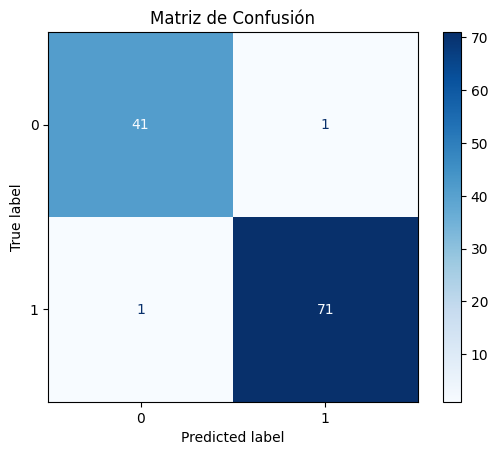


Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.98      0.98      0.98        42
     Default       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [ ]:
""" 
3)
"""

from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True, as_frame=True)


# Dividimos el set en entranamiento y test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

display(X_train.head())


# Ahora estadarizamos
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

display(X_train_scaled.head())


# Entrenamiento del modelo
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)


# Matriz de Confusion y reporte de clasificacion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title(f"Matriz de Confusión")
plt.grid(False)
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))


In [ ]:
"""
4)
Un punto en la esquina superior es decir, el punto (0, 1), indicaria que nuestro modelo clasifica perfectament.
Mientras que un punto en la linea diagonal, daria una clasificacion totalmente aleatoria
"""

In [ ]:
""" 
5)
Si 'fitiamos' todo el dataset (entrenamiento + test), estariamos fugando datos, de puntos que el modelo no deberia haber visto
"""

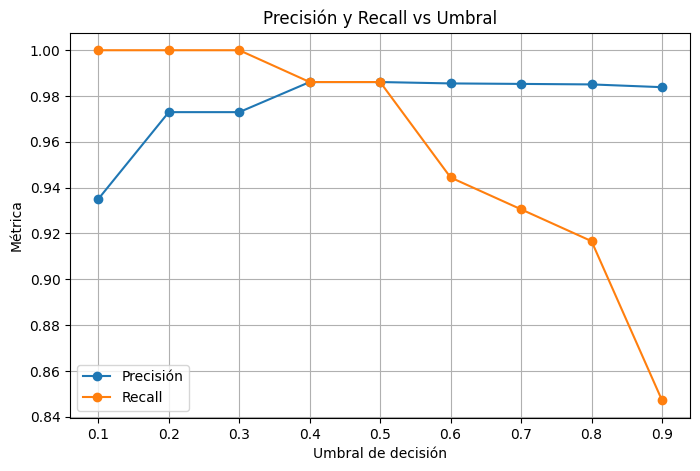

In [36]:
""" 
6) 
"""
from sklearn.metrics import precision_score, recall_score

umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []

# Obtenemos las probabilidades de predicción para la clase positiva (Default)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

for umbral in umbrales:
    y_pred_nuevo_umbral = (y_pred_proba >= umbral).astype(int)

    precision = precision_score(y_test, y_pred_nuevo_umbral)
    precisions.append(precision)
    
    recall = recall_score(y_test, y_pred_nuevo_umbral)
    recalls.append(recall)


plt.figure(figsize=(8, 5))
plt.plot(umbrales, precisions, label='Precisión', marker='o')
plt.plot(umbrales, recalls, label='Recall', marker='o')
plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Precisión y Recall vs Umbral')
plt.xticks(umbrales)
plt.legend()
plt.grid(True)
plt.show()

In [51]:
""" 
7)
Las odds = p/(1-p), es decir la probablidad de que sea 'Default' vs la probabilidad de 'No Default'
El aumento de 1 desviacion standard del coef de Balance, haria el ratio de odds de 'Default' incremente en e^2.17 veces
"""

print(f'El coeficiente de balance es: {log_reg.coef_[0,0]:.2f}')

El coeficiente de balance es: 2.71


In [ ]:
""" 
8)
La regularizacion L2, penaliza la suma de cuadrados de los coeficientes, pero nunca los lleva a 0
La regularizacion L1, en cambio, penaliza los valores absolutos, lo que posibilita que los coeficientes sean 0, ralizando asi una seleccion de caracteristicas (puede eliminar variables)
"""

In [ ]:
""" 
9)
El AUC mide la capacidad del modelo de distinguir entre clases. En general se preferiria el modelo con el AUC mas alto (0.85).
Pero puede existir la posibilidad de que, querramos buscar un modelo con mejor Recall, a coste de que el AUC disminuya (como en el ejemplo del banco)
"""

Reporte de Clasificación con Umbral:
              precision    recall  f1-score   support

  No Default       1.00      0.85      0.92      1933
     Default       0.17      0.88      0.29        67

    accuracy                           0.85      2000
   macro avg       0.58      0.87      0.60      2000
weighted avg       0.97      0.85      0.90      2000



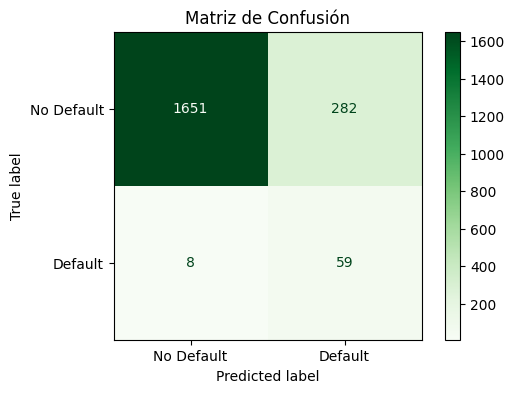

In [55]:
""" 
10)
"""
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print(f"Reporte de Clasificación con Umbral:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

# Visualizamos la nueva matriz de confusión
cm_nuevo = confusion_matrix(y_test, y_pred)
disp_nuevo = ConfusionMatrixDisplay(confusion_matrix=cm_nuevo, display_labels=['No Default', 'Default'])
fig, ax = plt.subplots(figsize=(6, 4))
disp_nuevo.plot(cmap='Greens', ax=ax)
ax.set_title(f'Matriz de Confusión')
plt.show()